<a href="https://www.kaggle.com/code/andriybabiy/02-image-classification-intel-image-classification?scriptVersionId=198828585" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 02_Image_Classification
Using the Intel Image Classification dataset, my goal is to develop and train a deep learining model that will attempt to correctly classify the images.

In [1]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

## Download and prepare the data for processing

In [2]:
# Kaggle
path_to_dir = '/kaggle/input/intel-image-classification'

pred = '/kaggle/input/intel-image-classification/seg_pred'
test = '/kaggle/input/intel-image-classification/seg_test/seg_test'
train = '/kaggle/input/intel-image-classification/seg_train/seg_train'

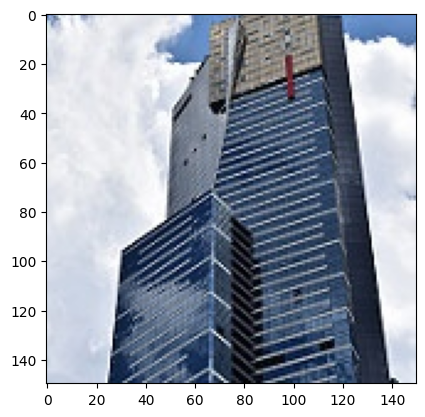

In [3]:
im = Image.open('/kaggle/input/intel-image-classification/seg_test/seg_test/buildings/20057.jpg')
plt.imshow(im)
plt.show() # image will not be displayed without this

### Transformations

In [4]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.filenames = []
        self.labels = []
        self.class_names = []
        
        # Traverse the directory structure
        for root, dirs, files in os.walk(data_dir):
            # Get the class name based on the folder name
            class_name = os.path.basename(root)
            
            if len(files) > 0:
                # Append all file paths and assign labels based on folder name
                for filename in files:
                    if filename.endswith('.jpg'):
                        self.filenames.append(os.path.join(root, filename))
                        # Use the class name (parent folder name) as the label
                        if class_name not in self.class_names:
                            self.class_names.append(class_name)
                        label = self.class_names.index(class_name)
                        self.labels.append(label)
                        
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        image_path = self.filenames[idx]
        image = Image.open(image_path).convert("RGB")  # Open and convert to RGB
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [5]:
resize_size = (64, 64)

transform_train = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
train_dataset = ImageDataset(train, transform_train)
test_dataset = ImageDataset(test, transform)
val_dataset = ImageDataset(pred, transform)

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=1)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=1)

### Display image examples

In [8]:
def imshow(images, labels, class_names):
    
    images = images.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    plt.title(", ".join([class_names[l] for l in labels]))
    plt.show()
    
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

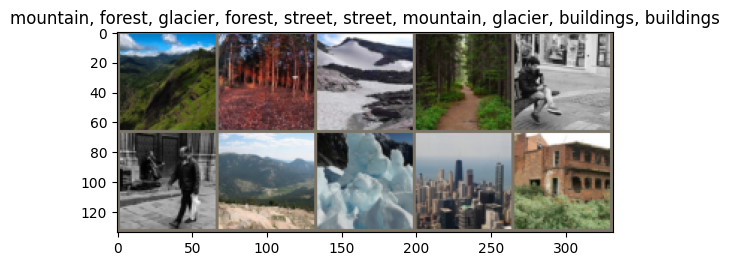

In [9]:
imshow(make_grid(images[:10], nrow=5), labels[:10], test_dataset.class_names)

### Insights about the classes

In [10]:
print(f"Amount of classes: {len(test_dataset.class_names)}")
print(f"Classes: {test_dataset.class_names}")
print(f"Size of training dataset: {len(train_dataset)}")
print(f"Size of test dataset: {len(test_dataset)}")
print(f"Size of validation dataset: {len(val_dataset)}")

class_counts = {class_name: 0 for class_name in train_dataset.class_names}
for label in train_dataset.labels:
    class_counts[train_dataset.class_names[label]]+=1

print("\nDistribution of classes in the training dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Amount of classes: 6
Classes: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']
Size of training dataset: 14034
Size of test dataset: 3000
Size of validation dataset: 7301

Distribution of classes in the training dataset:
mountain: 2512
street: 2382
buildings: 2191
sea: 2274
forest: 2271
glacier: 2404


## Develop the architecture for a convolutional neural network (CNN) for image classification

### Baseline Model

In [11]:
class BaselineModel(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.num_channels = 32
        
        self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)
        
        self.fc1 = nn.Linear(8*8*self.num_channels*4, self.num_channels*4)
        self.fc2 = nn.Linear(self.num_channels*4, 6)
        
    def forward(self, s):
        s = self.conv1(s)
        s = F.relu(F.max_pool2d(s, 2))
        s = self.conv2(s)
        s = F.relu(F.max_pool2d(s, 2))
        s = self.conv3(s)
        s = F.relu(F.max_pool2d(s, 2))
        
        s = s.view(-1, 8*8*self.num_channels*4)
        
        s = F.relu(self.fc1(s))
        s = self.fc2(s)
        
        return F.log_softmax(s, dim=1)

In [12]:
cuda = torch.cuda.is_available()

torch.manual_seed(42)
if cuda:
    torch.cuda.manual_seed(42)

device = 'cuda' if cuda else None

In [13]:
model = BaselineModel().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

train_losses = []
train_accs = []

test_losses = []
test_accs = []

num_epochs = 15

In [14]:
model

BaselineModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

In [23]:
for epoch in tqdm(range(num_epochs)):
    
    # train step
    
    model.train()
    
    train_epoch_loss = []
    train_epoch_acc = []
    
    for i, (train_batch, labels_batch) in tqdm(enumerate(train_dataloader), disable=True):
        if cuda:
            train_batch, labels_batch = train_batch.cuda(non_blocking = True), labels_batch.cuda(non_blocking=True)
            
        output_batch = model(train_batch)
        
        loss = criterion(output_batch, labels_batch)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        batch_loss = loss.cpu().detach().numpy()
        batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                                           labels_batch.cpu().detach().numpy())
        
        train_epoch_loss.append(batch_loss)
        train_epoch_acc.append(batch_acc)
        
    print(f'Train epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(train_epoch_loss):.4f}, Acc: {np.mean(train_epoch_acc)}')
    train_accs.append(np.mean(train_epoch_acc))
    train_losses.append(np.mean(train_epoch_loss))
        
    # eval step
    
    model.eval()
    
    test_epoch_loss = []
    test_epoch_acc = []
    
    with torch.no_grad():
        for i , (test_batch, labels_batch) in enumerate(test_dataloader):
            if cuda:
                test_batch, labels_batch = test_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)
                
            output_batch = model(test_batch)
            
            loss = criterion(output_batch, labels_batch)
            
            batch_loss = loss.cpu().detach().numpy()
            batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                                               labels_batch.cpu().detach().numpy())
            
            test_epoch_loss.append(batch_loss)
            test_epoch_acc.append(batch_acc)
            
    print(f'Test Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(test_epoch_loss):.4f}, Acc: {np.mean(test_epoch_acc)}')
    test_accs.append(np.mean(test_epoch_acc))
    test_losses.append(np.mean(test_epoch_loss))

  0%|          | 0/15 [00:00<?, ?it/s]

Train epoch [1/15], Loss: 0.0494, Acc: 0.9829711038139285


  7%|▋         | 1/15 [00:16<03:50, 16.46s/it]

Test Epoch [1/15], Loss: 1.0587, Acc: 0.33256501182033094
Train epoch [2/15], Loss: 0.0581, Acc: 0.9794387606403551


 13%|█▎        | 2/15 [00:32<03:32, 16.33s/it]

Test Epoch [2/15], Loss: 1.2174, Acc: 0.2970938104448742
Train epoch [3/15], Loss: 0.0657, Acc: 0.9779892015939852


 20%|██        | 3/15 [00:48<03:14, 16.23s/it]

Test Epoch [3/15], Loss: 1.1320, Acc: 0.3264560018881827
Train epoch [4/15], Loss: 0.0543, Acc: 0.9833653227730675


 27%|██▋       | 4/15 [01:05<02:59, 16.34s/it]

Test Epoch [4/15], Loss: 1.0487, Acc: 0.3285866261398176
Train epoch [5/15], Loss: 0.0563, Acc: 0.9830350555122765


 33%|███▎      | 5/15 [01:21<02:42, 16.26s/it]

Test Epoch [5/15], Loss: 1.0997, Acc: 0.32558625771391725
Train epoch [6/15], Loss: 0.0444, Acc: 0.9857956421794691


 40%|████      | 6/15 [01:37<02:25, 16.21s/it]

Test Epoch [6/15], Loss: 1.2082, Acc: 0.3185998596730762
Train epoch [7/15], Loss: 0.0538, Acc: 0.9840236101113095


 47%|████▋     | 7/15 [01:53<02:08, 16.12s/it]

Test Epoch [7/15], Loss: 1.2547, Acc: 0.33568161669890384
Train epoch [8/15], Loss: 0.0446, Acc: 0.9862551194271012


 53%|█████▎    | 8/15 [02:10<01:53, 16.28s/it]

Test Epoch [8/15], Loss: 1.2665, Acc: 0.32319908814589665
Train epoch [9/15], Loss: 0.0668, Acc: 0.9800400042882959


 60%|██████    | 9/15 [02:26<01:37, 16.23s/it]

Test Epoch [9/15], Loss: 1.2456, Acc: 0.32532928064842953
Train epoch [10/15], Loss: 0.0483, Acc: 0.9848205106291668


 67%|██████▋   | 10/15 [02:42<01:20, 16.17s/it]

Test Epoch [10/15], Loss: 1.2374, Acc: 0.3150544579533941
Train epoch [11/15], Loss: 0.0386, Acc: 0.9890129437339005


 73%|███████▎  | 11/15 [02:58<01:04, 16.22s/it]

Test Epoch [11/15], Loss: 1.3749, Acc: 0.3328875667771944
Train epoch [12/15], Loss: 0.0486, Acc: 0.9845763470478733


 80%|████████  | 12/15 [03:15<00:48, 16.30s/it]

Test Epoch [12/15], Loss: 1.3722, Acc: 0.3078043410490219
Train epoch [13/15], Loss: 0.0402, Acc: 0.989197680957362


 87%|████████▋ | 13/15 [03:31<00:32, 16.19s/it]

Test Epoch [13/15], Loss: 1.2146, Acc: 0.3252125644745325
Train epoch [14/15], Loss: 0.0435, Acc: 0.9860514818430536


 93%|█████████▎| 14/15 [03:47<00:16, 16.25s/it]

Test Epoch [14/15], Loss: 1.4554, Acc: 0.31475289879545193
Train epoch [15/15], Loss: 0.0413, Acc: 0.9881330388164101


100%|██████████| 15/15 [04:03<00:00, 16.26s/it]

Test Epoch [15/15], Loss: 1.3893, Acc: 0.35234517477203653


## Train the model on the training dataset

## Analyze the effectiveness of the model using the valid and test datasets

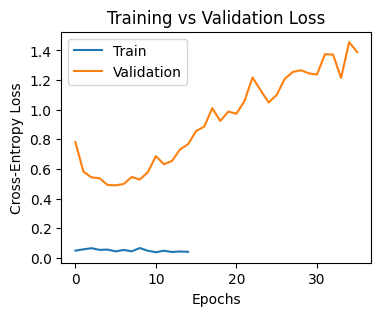

In [26]:
plt.figure(figsize=(4, 3))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training vs Validation Loss')
plt.show()

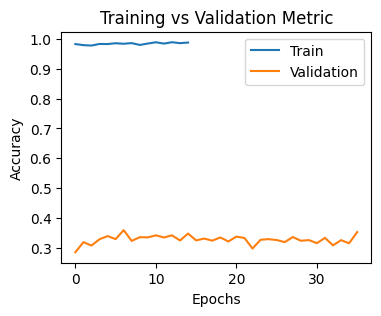

In [27]:
plt.figure(figsize=(4, 3))
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Metric')
plt.show()

In [16]:
def visualize_predictions(model, dataloader, class_names, num_images=5):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.show()
                    return

                images_so_far += 1
                ax = plt.subplot(num_images//2 + 1, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}')

                # Денормалізація зображення для відображення
                inv_normalize = transforms.Normalize(
                    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                    std=[1/0.229, 1/0.224, 1/0.225]
                )
                inp = inv_normalize(inputs.cpu()[j]).numpy().transpose((1, 2, 0))
                inp = np.clip(inp, 0, 1)

                plt.imshow(inp)

    model.train(mode=was_training)
    plt.tight_layout()
    plt.show()

In [17]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [18]:
model.load_state_dict(torch.load('best_model_1.pth'))
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

FileNotFoundError: [Errno 2] No such file or directory: 'best_model_1.pth'

In [ ]:
class_names = train_dataset.class_names

# Обчислення точності та F1
test_accuracy = correct / total
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

# Створення матриці помилок
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

In [ ]:
visualize_predictions(model, test_loader, train_dataset.class_names, 15)

## Analyze the results and proposal of further potential improvements of the model

After the initial run of the custom model, even during the state of training the model it was clearly evident that the model was overfitting as the model was improving its performance on the train dataset while slowly getting worse on the test dataset. 